In [9]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual

from NumericalMethods import *


In [22]:
# Interact Manual
def plot_sine_wave_manual(amplitude, frequency, phase):
    # Create a figure and axis
    fig, ax = plt.subplots()
    x = np.linspace(0, 2*np.pi, 1000)
    y = amplitude*np.sin(frequency*x + phase)
    ax.plot(x, y)
    plt.show()

# Example usage
ex = interact_manual(plot_sine_wave_manual, amplitude=(0, 10, 0.1), frequency=(1, 10, 0.1), phase=(0, 2*np.pi, 0.1))
ex.widget.children[3].description = 'Update Plot'

interactive(children=(FloatSlider(value=5.0, description='amplitude', max=10.0), FloatSlider(value=5.0, descri…

In [11]:
# Function to generate airfoil coordinates
def naca_airfoil4(max_camber, camber_position, thickness, num_points=100, length=1, centrepos=0.5):
    """
    Generates a 4-digit NACA airfoil based on the given parameters, with variable length and centering position.

    Using Wikipedia's parameterization for a 4-digit NACA airfoil for symmetric airfoils, and NACA's original equations for cambered airfoils.

    Parameters:
    max_camber (float): Maximum camber as a percentage of the chord (0 to 9.9).
    camber_position (float): Position of maximum camber as a fraction of the chord (0 to 0.9).
    thickness (float): Maximum thickness as a percentage of the chord (0 to 40).
    num_points (int): Number of points to generate for the airfoil (default: 100).
    length (float): Length of the airfoil (chord length). Defaults to 1.
    centrepos (float): Position along the chord at which the airfoil will be centered (0 to 1).

    Returns:
    numpy.ndarray: Array of airfoil coordinates with columns for x and y coordinates.
    """
    # Convert max_camber and thickness to decimals
    m = max_camber / 100
    p = camber_position / 10
    t = thickness / 100
    
    # Generate x-coordinates with cosine spacing
    beta = np.linspace(0, np.pi, num_points)
    x = 0.5 * (1 - np.cos(beta))
    
    # Initialize y-coordinates for camber line (yc) and thickness distribution (yt)
    yc = np.zeros_like(x)
    dyc_dx = np.zeros_like(x)
    yt = 5 * t * (0.2969 * np.sqrt(x) - 0.1260 * x - 0.3516 * x**2 + 0.2843 * x**3 - 0.1015 * x**4)
    
    # Compute yc and dyc_dx based on the position of maximum camber (p)
    for i in range(num_points):
        if x[i] < p:
            yc[i] = (m / p**2) * (2 * p * x[i] - x[i]**2)
            dyc_dx[i] = (2 * m / p**2) * (p - x[i])
        else:
            yc[i] = (m / (1 - p)**2) * ((1 - 2 * p) + 2 * p * x[i] - x[i]**2)
            dyc_dx[i] = (2 * m / (1 - p)**2) * (p - x[i])
    
    # Calculate the angle (theta) for each point
    theta = np.arctan(dyc_dx)
    
    # Calculate upper and lower surface coordinates
    xu = x - yt * np.sin(theta)
    yu = yc + yt * np.cos(theta)
    xl = x + yt * np.sin(theta)
    yl = yc - yt * np.cos(theta)
    
    # Combine upper and lower surface points; start at trailing edge and move along upper surface
    # back to the leading edge, then along the lower surface to form a closed loop
    x_coords = np.concatenate([xu[::-1], xl[1:]])
    y_coords = np.concatenate([yu[::-1], yl[1:]])
    
    # Scale by the length parameter, then center along the chord
    x_coords *= length
    y_coords *= length
    x_coords -= centrepos * length
    
    # Return as a two-column array
    airfoil_coords = np.column_stack((x_coords, y_coords))
    
    return airfoil_coords

def linear_spring(k_theta, num_coils, coil_radius, num_points=100):
    """
    Generates coordinates for a torsional spring based on the given spring constant.

    Parameters:
    k_theta (float): Spring constant for the torsional spring.
    num_coils (int): Number of coils in the spring.
    coil_radius (float): Radius of the coils in the spring.
    num_points (int): Number of points to generate for the spring (default: 100).

    Returns:
    numpy.ndarray: Array of spring coordinates with columns for x and y coordinates.
    """

    # Generate the spring coordinates
    theta = np.linspace(0, 2 * np.pi * num_coils, num_points)
    x = coil_radius * np.cos(theta)
    y = coil_radius * np.sin(theta) + k_theta * theta

    # Combine x and y coordinates
    spring_coords = np.column_stack((x, y))

    return spring_coords



class SupportBeam:
    def __init__(self, x_start, x_end, y_position, height, width):
        # Generate the support beam coordinates as a 1x1 square
        x = np.array([0, 1, 1, 0, 0])
        y = np.array([0, 0, 1, 1, 0])

        # Scale with height and width
        x = x * width
        y = y * height

        # Combine x and y coordinates
        self._beam = np.column_stack((x, y))

        self._height = height
        self._width = width

    @property
    def beam(self):
        return self._beam

    @property
    def height(self):
        return self._height

    @property
    def width(self):
        return self._width



def support_beam(height,width):
    """
    Generates coordinates for a support beam based on the given height and width.

    Parameters:
    height (float): Height of the support beam.
    width (float): Width of the support beam.

    Returns:
    numpy.ndarray: Array of support beam coordinates with columns for x and y coordinates.
    """

    # # Generate the support beam coordinates
    # x = np.array([0, width, width, 0, 0])
    # y = np.array([0, 0, height, height, 0])
    
    #Generate 1 by 1 square
    x = np.array([0, 1, 1, 0, 0])
    y = np.array([0, 0, 1, 1, 0])

    #Scale with height and width
    x = x * width
    y = y * height


    # Combine x and y coordinates
    support_coords = np.column_stack((x, y))

    return support_coords

In [12]:
# Parameters
initial_angle = 15  # deg °
frequency = 1.0  # Hz
damping_factor = 0.03
duration = 10  # s(econds)

airfoil_length = 5#st.slider("Airfoil Length",0,10,1)#Chord Length
x_cm = 0.25#Centre of mass location as a ratio along chord length#st.slider("Airfoil Centre",0,1,0.5)#convert to streamlit slider later
x_r = x_cm#Centre of rotation location as a ratio along chord length

x_ac = 0.1# Aerodynamic Centre - where aerodynamic forces are assumed to act

plunge_amplitude = 1#st.slider("Plunge Amplitude",0,1,0.1)#convert to streamlit slider later,. set to 0 for only twist mode

fps = 30  # frames per second

initial_angle_rad = np.radians(initial_angle)#convert initial angle to radians

t = np.linspace(0, duration, duration * fps)#create discretized time series



In [13]:
# Flutter simulation functions for a simplified 2D model  
'''
Torsional Flutter is a phenomenon that occurs when the angle of attack of an airfoil changes due to aerodynamic forces acting on the airfoil.
The angle of attack is the angle between the chord line of the airfoil and the relative wind direction.

Plunging portion of flutter occurs when the airfoil moves up and down (plunges) due to aerodynamic forces acting on the airfoil.
Twisting portion of flutter occurs when the airfoil twists about its chord line/support position due to aerodynamic forces acting on the airfoil.
'''
def torsional_flutter(t, initial_angle, frequency, damping):
    return initial_angle * np.exp(damping * t) * np.sin(2 * np.pi * frequency * t) #Function f(x) = A*e(c*t)*sin(2*pi*w*t), which is the angle at every time t - replace with torsional flutter equation of motion from vki lecture pt 1


angle = torsional_flutter(t, initial_angle_rad, frequency, damping_factor)




# Linear set of structural dynamic equations coupled with
# Linear set of aerodynamic forces resulting from structural deformation


RuntimeError: x must be a sequence

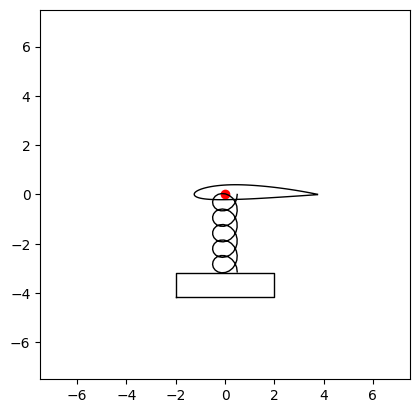

In [14]:
# Define airfoil then centre it at the origin
airfoil = naca_airfoil4(2, 4, 12, num_points=50, length=airfoil_length, centrepos=x_cm)

# Define springs
l_spring = linear_spring(0.1, 5, 0.5, num_points=100)

# Create an instance of the SupportBeam class with x_start and x_end centered about the origin
support_beam = SupportBeam(-0.5, 0.5, -0.5, 1, 4)


# Matplotlib Plot setup
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-airfoil_length * 1.5, airfoil_length * 1.5)
ax.set_ylim(-airfoil_length * 1.5, airfoil_length * 1.5)

origin, = ax.plot(0, 0, 'ro', lw=1)#origin point

#center_line, = ax.plot([0, 0], [-airfoil_length * 1.5, airfoil_length * 1.5], 'black', lw=1)#centre line

#place spring between airfoil centre and centre of support beam
# spring_line, = ax.plot(l_spring[:, 0], -1 *l_spring[:, 1], 'black', lw=1)# multiply by -1 to flip the spring below the origin point
linear_spring_line, = ax.plot(l_spring[:, 0] - np.mean(l_spring[:, 0]), -1 *l_spring[:, 1], 'black', lw=1)# multiply by -1 to flip the spring below the origin point

# Plot the support beam centered at the origin
# Calculate the y-offset for the support beam
y_offset = support_beam.height + np.max(l_spring[:, 1])
support_beam_shape = ax.plot(support_beam.beam[:, 0] - 0.5 * support_beam.width, support_beam.beam[:, 1] - y_offset, 'black', lw=1)

# Define airfoil as a polygon that rotates around its center
airfoil_line, = ax.plot([], [], 'black', lw=1)

### Replace animation function with matrix eom multiplication at each timestep to precompute the airfoil positions for each timestep, reducing the computation time needed for the animation.###
def animate(i):
    theta = angle[i]  # Current angle in radians
    plunge = plunge_amplitude * np.sin(2 * np.pi * frequency * t[i])#calculate plunge at each time step

    # Rotate the airfoil
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    rotated_airfoil = airfoil @ rotation_matrix.T#dot product of airfoil and rotation matrix transposed

    # Plunge the airfoil
    rotated_airfoil[:, 1] += plunge
    airfoil_line.set_data(rotated_airfoil[:, 0], rotated_airfoil[:, 1])

    #Plunge the origin point
    origin.set_data(0, plunge)

    
    
    return airfoil_line,


flutter_ani = FuncAnimation(fig, animate, frames=len(t), interval=1000/fps, blit=True)# Create animation with blitting enabled; only the parts of the plot that have changed are redrawn for each frame

# Display the animation in Jupyter Notebook
HTML(flutter_ani.to_jshtml())



In [ ]:
airfoil_data = airfoil
# Calculate the center of the airfoil
center = np.mean(airfoil_data, axis=0)

# Translate the airfoil to the origin
airfoil_centered = airfoil_data - center

# Precompute the positions of the airfoil at each time step
precomputed_positions = []

for theta in angle:
    # Rotate the airfoil
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    rotated_airfoil = airfoil_centered @ rotation_matrix.T
    # Translate the airfoil back to its original position
    rotated_airfoil += center
    precomputed_positions.append(rotated_airfoil)



In [ ]:
# Plotly Plot setup
fig = go.Figure()

# Add initial airfoil position
fig.add_trace(go.Scatter(x=precomputed_positions[0][:, 0], y=precomputed_positions[0][:, 1], mode='lines', name='Airfoil'))

# Create frames for the animation
frames = []
for i in range(len(t)):
    rotated_airfoil = precomputed_positions[i]
    plunge = plunge_amplitude * np.sin(2 * np.pi * frequency * t[i])  # Calculate plunge at each time step
    rotated_airfoil[:, 1] += plunge  # Apply plunge motion
    frames.append(go.Frame(data=[go.Scatter(x=rotated_airfoil[:, 0], y=rotated_airfoil[:, 1], mode='lines', name='Airfoil')]))

# Add frames to the figure
fig.frames = frames

# Update layout for animation with a dark theme
fig.update_layout(
    template="plotly_dark",
    title="Flutter Simulation",
    xaxis_title="x",
    yaxis_title="y",
    xaxis_range=[-5,5],#[-airfoil_length * 1.5, airfoil_length * 1.5],
    yaxis_range=[-5,5],#[-airfoil_length * 1.5, airfoil_length * 1.5],
    showlegend=False,
    updatemenus=[{
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 1000 / fps, "redraw": True}, "fromcurrent": True}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate", "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }],
)

# Add origin point
fig.add_trace(go.Scatter(x=[0], y=[0], mode='markers', marker=dict(color='red'), name='Origin'))
# Show the figure
fig.show()